# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [2]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from scipy.signal.windows import hann
from scipy.signal import stft


## Functions

In [3]:
def load_sound(file):
    return wave.open(file, "rb")


def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return p, x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    _, Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced


def load_music(filename):
    data_path = os.getcwd()
    sound = os.path.join(data_path, filename)
    wavefile = load_sound(sound)

    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack("{n}h".format(n=num_samples), data)
    x = np.array(data)

    return x, Fs, wavefile.getparams()


## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [4]:
data_path = "sons/"
filename = "aeiou.wav"
sound = os.path.join(data_path, filename)


### **Using wave**

In [5]:
wavefile = load_sound(sound)
print(wavefile.getparams())


_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [7]:
Audio("sons/aeiou.wav")


In [8]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack("{n}h".format(n=num_samples), data)
x = np.array(data)


In [9]:
timestep = 1 / float(Fs)
times = np.arange(len(x)) * timestep


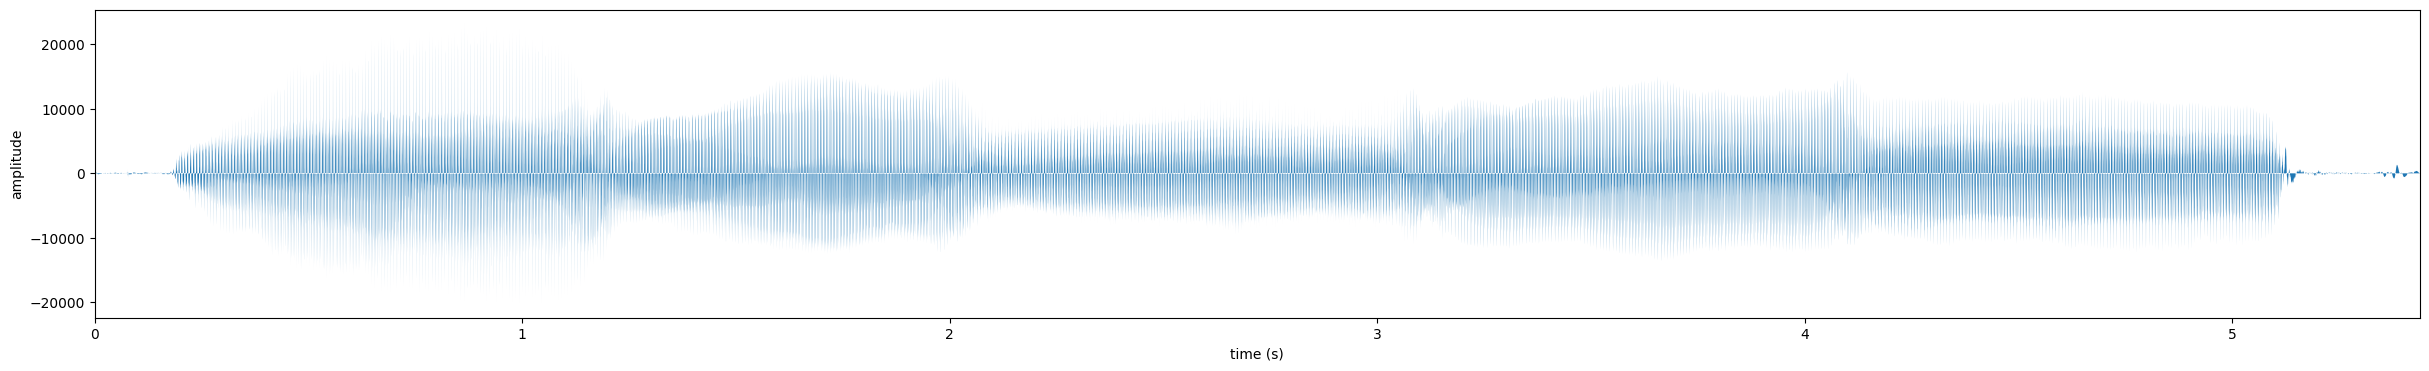

In [10]:
plot_sound(x, times)


In [11]:
write("sons/new_aeiou.wav", Fs, np.array(x, dtype=np.int16))  # to write a new wave file


## 1- Extraction of the analysis marks

In [12]:
def analysis_pitch_marks(s, Fs):
    ta = [0]
    pa = [10e-3 * Fs]
    v = [False]
    while ta[-1] < len(s):
        try:
            seq = s[ta[-1] : min(len(s), ta[-1] + int(2.5 * pa[-1]))]
            pa_n, v_n = period(seq, Fs)
            pa.append(pa_n)
            v.append(v_n)
            ta.append(int(ta[-1] + pa_n))
        except Exception as e:
            break
    return np.stack((ta, v, pa), axis=0)


Text(0.5, 1.0, 'Analysis marks on an_in_on')

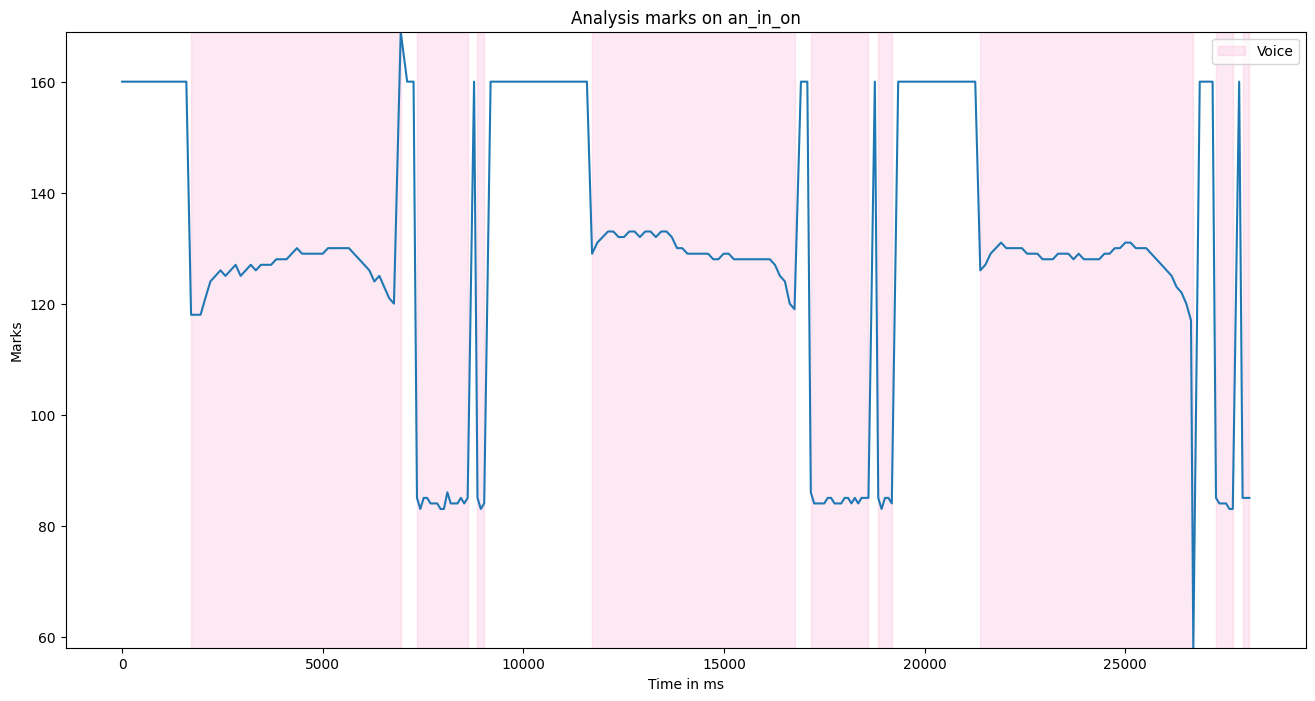

In [15]:
def analysis_pitch_marks(s, Fs):
    ta = [0]
    pa = [10e-3 * Fs]
    v = [False]
    while ta[-1] + int(2.5 * pa[-1]) < len(s):
        seq = s[ta[-1] : ta[-1] + int(2.5 * pa[-1])]
        pa_n, v_n = period(seq, Fs)
        pa.append(pa_n)
        v.append(v_n)
        ta.append(int(ta[-1] + pa_n))
    return np.stack((ta, v, pa), axis=0)


x, Fs, params = load_music("sons/an_in_on.wav")
A = analysis_pitch_marks(x, Fs)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(A[0, :], A[2, :])
ax.fill_between(
    A[0, :],
    where=A[1, :],
    y1=np.min(A[2, :]),
    y2=np.max(A[2, :]),
    color=(245 / 255, 40 / 255, 145 / 255, 0.1),
    label="Voice",
)
ax.legend()
ax.set_ylim((np.min(A[2, :]), np.max(A[2, :])))
ax.set_xlabel("Time in ms")
ax.set_ylabel("Marks")
ax.set_title("Analysis marks on an_in_on")


## 2- Synthesis and modification of the temporal and spectral scales

### 2.1- Signal synthesis

In [16]:
def synthesis(s, Fs, A, B):
    Ta = A[0, :]
    Pa = A[2, :]
    Ts = B[0, :]
    nk = B[1, :]

    k_end = len(B[0]) - 1
    y = np.zeros(int(Ts[k_end] + Pa[int(nk[k_end])]))

    for k in range(k_end + 1):
        seq = s[
            max(0, int(Ta[int(nk[k])] - Pa[int(nk[k])])) : int(
                Ta[int(nk[k])] + Pa[int(nk[k])]
            )
        ]
        w = np.hamming(len(seq))  # Window
        seq = seq * w
        y[
            max(0, int(Ts[k] + Pa[int(nk[k])]) - len(seq)) : int(Ts[k] + Pa[int(nk[k])])
        ] += seq
    return y


B = np.zeros((2, len(A[0])))
B[0, :] = A[0, :]
B[1, :] = np.arange(len(A[0]))

y = synthesis(x, Fs, A, B)
print("Original sound:")
display(Audio(x, rate=Fs))
print("Reconstructed sound:")
display(Audio(y, rate=Fs))


Original sound:


Reconstructed sound:


Hopefully, in this case, the reconstructed sound is the same.

### 2.2- Modification of the temporal scale

In [17]:
def change_time_scale(alpha, A, Fs):
    ts = [0]
    nk = [0]
    Pa = A[2, :]

    while int(nk[-1]) < len(Pa):
        ts.append(ts[-1] + Pa[int(nk[-1])])
        nk.append(nk[-1] + 1 / alpha)
    return np.stack((ts[:-1], nk[:-1]), axis=0).astype(int)


print("Original sound:")
display(Audio(x, rate=Fs))

print("Faster sound:")
B = change_time_scale(0.5, A, Fs)
y_fast = synthesis(x, Fs, A, B)
write("sons/fast_an_in_on.wav", Fs, np.array(y_fast, dtype=np.int16))
display(Audio(y_fast, rate=Fs))

print("Slower sound:")
B = change_time_scale(2, A, Fs)
y_slow = synthesis(x, Fs, A, B)
write("sons/slow_an_in_on.wav", Fs, np.array(y_slow, dtype=np.int16))
display(Audio(y_slow, rate=Fs))


Original sound:


Faster sound:


Slower sound:


We can also plot the original sound and the faster sound with respect to the time. 
If we rescale the faster sound so that it fits the original sound, we can check that 2 sounds match perfectly (up to a very small translation).

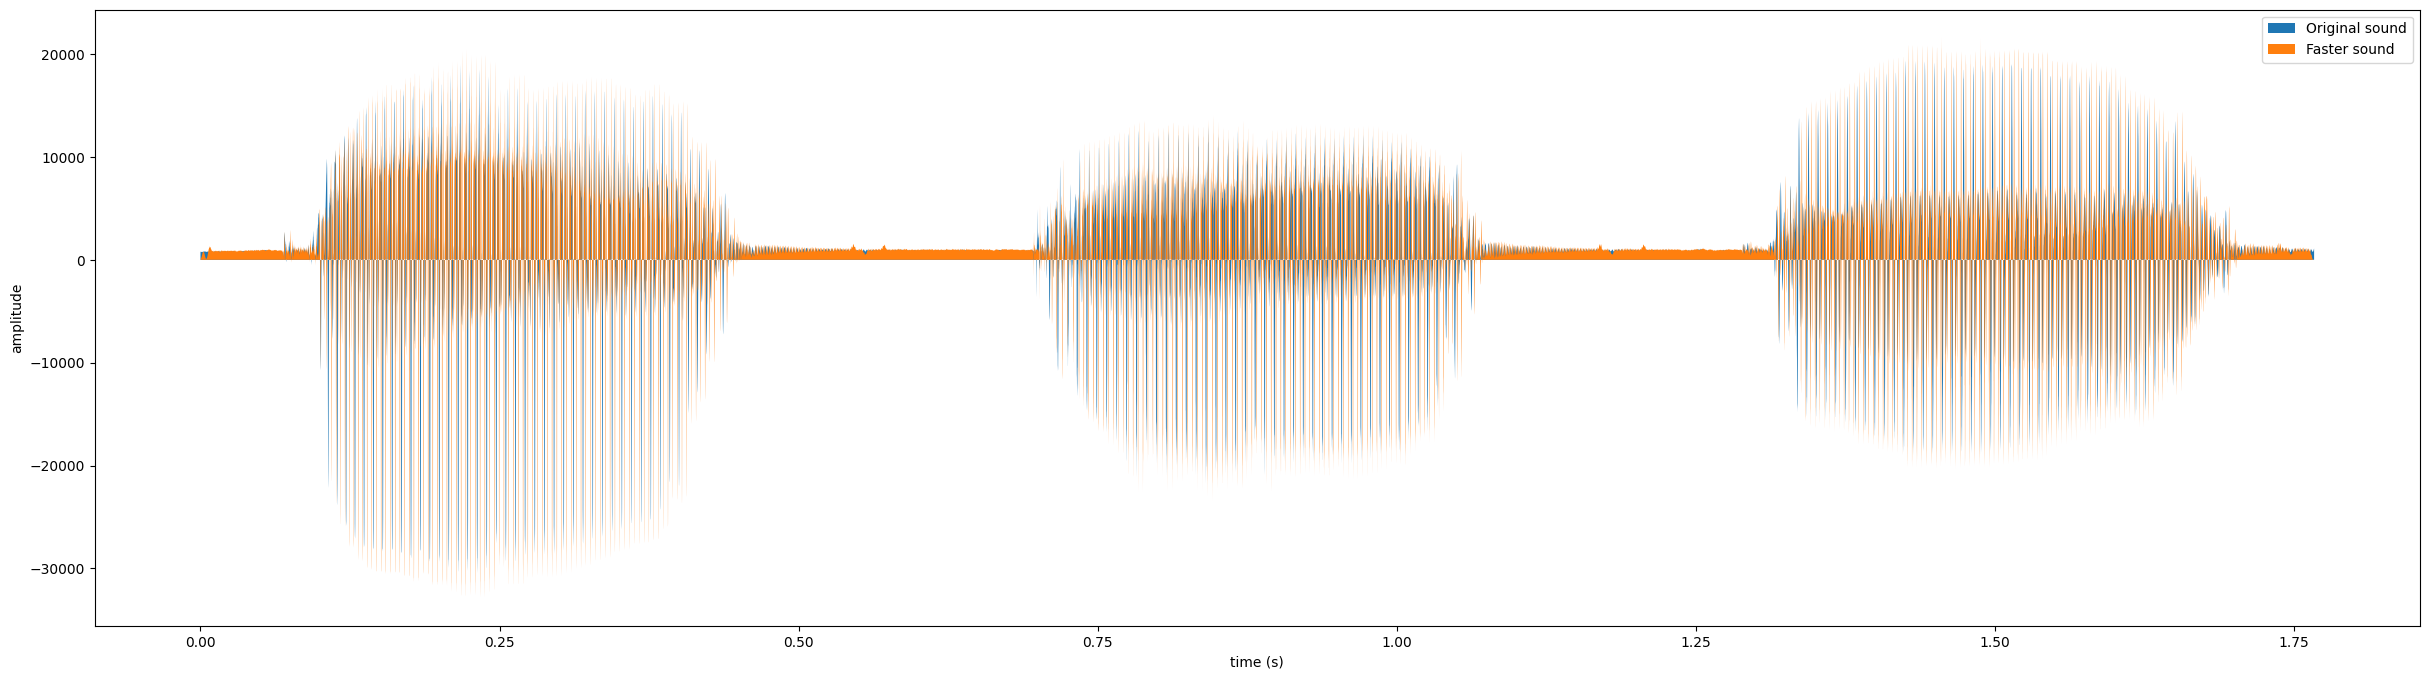

In [18]:
plt.figure(figsize=(30, 8))

timestep = 1 / float(Fs)
times = np.arange(len(x)) * timestep
plt.fill_between(times, x, label="Original sound")

timestep = 1 / float(Fs)
times = np.arange(len(y_slow)) * timestep
plt.fill_between(times / 2, y_slow, label="Faster sound")

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.show()


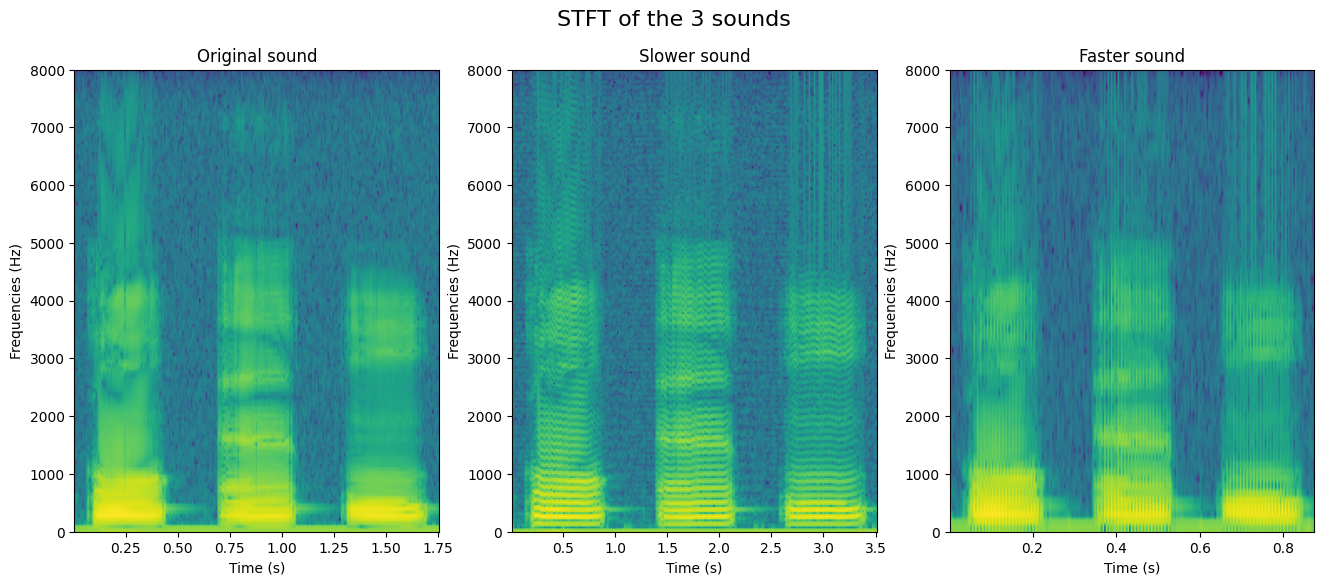

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("STFT of the 3 sounds", fontsize=16)
_ = axs[0].specgram(x, Fs=Fs)
axs[0].set_title("Original sound")
_ = axs[1].specgram(y_slow, Fs=Fs, noverlap=256, NFFT=512)
axs[1].set_title("Slower sound")
_ = axs[2].specgram(y_fast, Fs=Fs, noverlap=64, NFFT=128)
axs[2].set_title("Faster sound")

for i in range(3):
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Frequencies (Hz)")


We notice that the 3 STFT match ! (up to a dilation on x axis). However, it requires a bit of finetuning the plot to make them match.

We also notice that when the STFT is more precise / less pixaleted when the sound is longer. This is due to the fact that the STFT window will be relatively smaller compared to the sound window, when the sound length increases.

### 2.3- Modification of the spectral scale

In [20]:
def change_pitch_scale(beta, A, Fs):
    ts = [0]
    nk = [0]
    scale = []

    voice = A[1, :]
    Pa = A[2, :]

    while int(nk[-1]) < len(Pa):
        if voice[int(nk[-1])]:
            scale.append(1 / beta)
        else:
            scale.append(1)
        ts.append(ts[-1] + scale[-1] * Pa[int(nk[-1])])
        nk.append(nk[-1] + scale[-1])
    return np.stack((ts[:-1], nk[:-1]), axis=0).astype(int)


print("Original sound:")
display(Audio(x, rate=Fs))

print("Lower sound:")
B = change_pitch_scale(0.5, A, Fs)
y_low = synthesis(x, Fs, A, B)
write("sons/low_an_in_on.wav", Fs, np.array(y_low, dtype=np.int16))
display(Audio(y_low, rate=Fs))

print("Higher sound:")
B = change_pitch_scale(2, A, Fs)
y_high = synthesis(x, Fs, A, B)
write("sons/high_an_in_on.wav", Fs, np.array(y_high, dtype=np.int16))
display(Audio(y_high, rate=Fs))


Original sound:


Lower sound:


Higher sound:


The sounds have all a different pitch !

Once again, we can plot the original sound and the higher sound with respect to the time. 
We notice that the timesteps remain the same, but the notes are different.

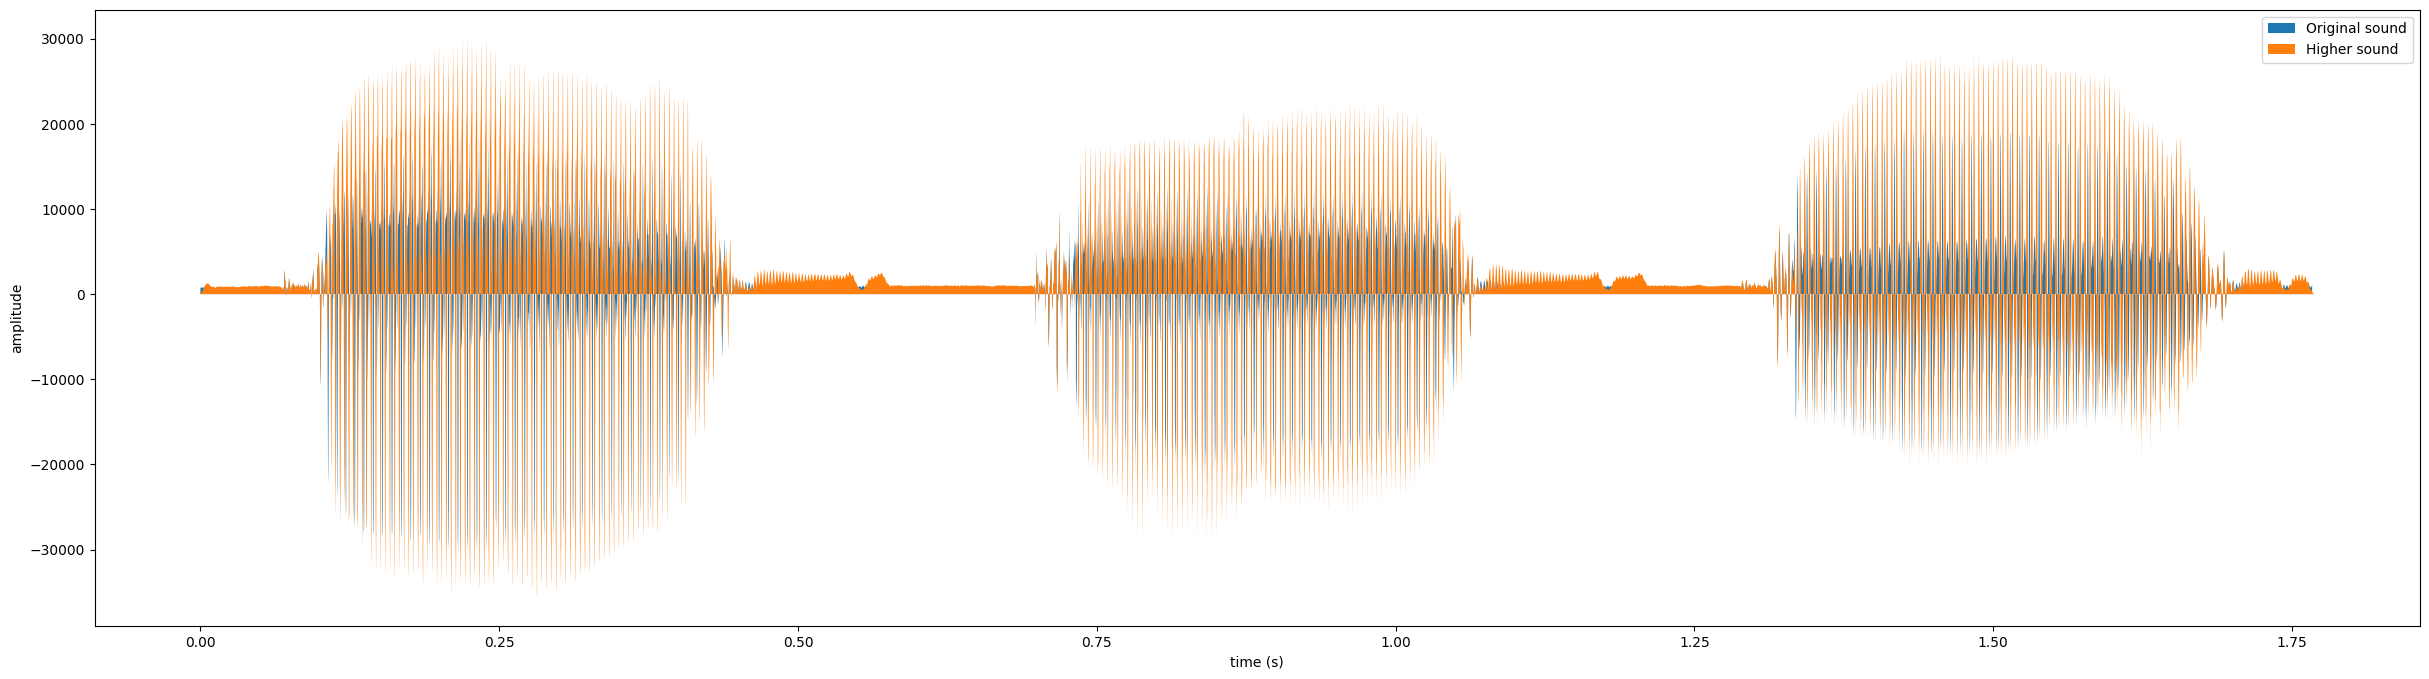

In [21]:
plt.figure(figsize=(30, 8))

timestep = 1 / float(Fs)
times = np.arange(len(x)) * timestep
plt.fill_between(times, x, label="Original sound")

timestep = 1 / float(Fs)
times = np.arange(len(y_high)) * timestep
plt.fill_between(times, y_high, label="Higher sound")

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.show()


Finally, we can also plot the STFT:

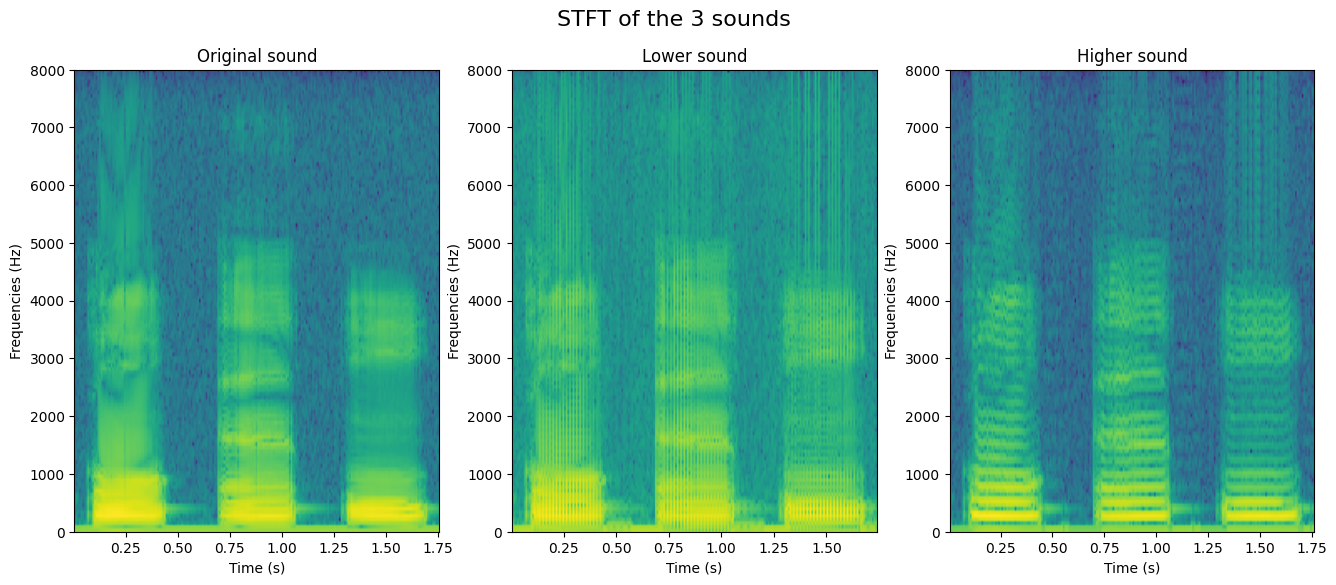

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle("STFT of the 3 sounds", fontsize=16)
_ = axs[0].specgram(x, Fs=Fs)
axs[0].set_title("Original sound")
_ = axs[1].specgram(y_low, Fs=Fs)
axs[1].set_title("Lower sound")
_ = axs[2].specgram(y_high, Fs=Fs)
axs[2].set_title("Higher sound")

for i in range(3):
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Frequencies (Hz)")


With spectral modifications, it is a bit harder to check for the differences in the STFT. I expected the STFT of the lower sound to be more blueish at the top and more yellow at the bottom.

### 2.4- Joint modification of the temporal and spectral scales

In [23]:
def change_both_scales(alpha, beta, A, Fs):
    ts = [0]
    nk = [0]
    scale = []

    voice = A[1, :]
    Pa = A[2, :]

    while int(nk[-1]) < len(Pa):
        if voice[int(nk[-1])]:
            scale.append(1 / beta)
        else:
            scale.append(1)
        ts.append(ts[-1] + scale[-1] * Pa[int(nk[-1])])
        nk.append(nk[-1] + scale[-1] / alpha)
    return np.stack((ts[:-1], nk[:-1]), axis=0).astype(int)


print("Original sound:")
display(Audio(x, rate=Fs))

print("Lower and Faster sound:")
B = change_both_scales(0.7, 0.7, A, Fs)
y_low_fast = synthesis(x, Fs, A, B)
write("sons/low_fast_an_in_on.wav", Fs, np.array(y_low_fast, dtype=np.int16))
display(Audio(y_low_fast, rate=Fs))

print("Higher and Slower sound:")
B = change_both_scales(1.3, 1.3, A, Fs)
y_high_slow = synthesis(x, Fs, A, B)
write("sons/high_slow_an_in_on.wav", Fs, np.array(y_high_slow, dtype=np.int16))
display(Audio(y_high_slow, rate=Fs))


Original sound:


Lower and Faster sound:


Higher and Slower sound:


We can do the same for the `aeiou.wav` sound:

In [25]:
x, Fs, params = load_music("sons/aeiou.wav")
A = analysis_pitch_marks(x, Fs)

print("Original sound:")
display(Audio(x, rate=Fs))

print("Lower and Faster sound:")
B = change_both_scales(0.8, 0.8, A, Fs)
y_low_fast = synthesis(x, Fs, A, B)
write("sons/low_fast_aeiou.wav", Fs, np.array(y_low_fast, dtype=np.int16))
display(Audio(y_low_fast, rate=Fs))

print("Higher and Slower sound:")
B = change_both_scales(1.2, 1.2, A, Fs)
y_high_slow = synthesis(x, Fs, A, B)
write("sons/high_slow_aeiou.wav", Fs, np.array(y_high_slow, dtype=np.int16))
display(Audio(y_high_slow, rate=Fs))

Original sound:


Lower and Faster sound:


Higher and Slower sound:


> PS: I almost never used $Fs$ when required. This is probably due to the fact that I coded everything with array indices and not timestamps.